## Copy of GIT


In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('torch version:',torch.__version__)
print('device:', device)

torch version: 2.0.0
device: cuda


In [3]:
img_size_x = 28 # Image size
img_size_y = 28 # Image size
batch_size = 64  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

# Training
epochs = 50  # Train epochs
learning_rate = 1e-4

In [4]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

class_list = train_data.classes
class_num = len(class_list)
class_list

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
train_loader = torch.utils.data.DataLoader(
        dataset= train_data,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        drop_last=False)

eval_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size,
    shuffle=False,
    pin_memory=True,
    drop_last=False)

Text(0.5, 1.0, 'Ankle boot')

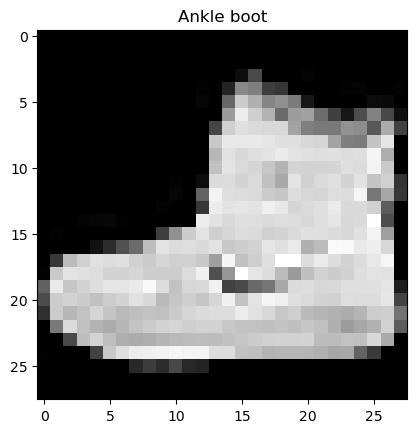

In [6]:
X, y = next(iter(train_loader))
plt.imshow(X[0].squeeze(axis=0), cmap='gray')
plt.title(class_list[y[0]])

In [7]:
class Generator(nn.Module):

    def __init__(self, generator_layer_size, z_size, img_size_x, img_size_y, class_num):
        super().__init__()

        self.z_size = z_size
        self.img_size_x = img_size_x
        self.img_size_y = img_size_y

        self.label_emb = nn.Embedding(num_embeddings=class_num, embedding_dim=5) # num = num of input labels (10), # dim = dum of output embedding (10) - change this value

        # Implement a CNN Conv2DTranspose
        self.model = nn.Sequential(
            nn.Linear(self.z_size + 5, generator_layer_size[0]), # class_num should be replaced by size(label_emb)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size_x * self.img_size_y),
            nn.Tanh()
        )

    def forward(self, z, labels):

        # Ensure input noise vector size
        z.view(-1, self.z_size)
        # convert integer encoding to embedding
        c = self.label_emb(labels)
        # concatate label and noise vector (aka condition the input data)
        x = torch.cat([z, c], 1)
        # get generated image
        out = self.model(x)
        # reshape and return output as an image
        return out.view(-1, self.img_size_x, self.img_size_y)
            

In [8]:
class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size_x, img_size_y, class_num):
        super().__init__()

        self.label_emb = nn.Embedding(class_num, 5)
        self.img_size_x = img_size_x
        self.img_size_y = img_size_y

        self.model = nn.Sequential(
            nn.Linear(self.img_size_x * self.img_size_y + 5, discriminator_layer_size[0]), # class_num should be replaced by size(label_emb)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
    
        # Reshape fake image
        x = x.view(-1, self.img_size_x * self.img_size_y)
        
        # One-hot vector to embedding vector
        c = self.label_emb(labels)
        
        # Concat image & label
        x = torch.cat([x, c], 1)
        
        # Discriminator out
        out = self.model(x)
        
        return out.squeeze()

In [9]:
# Define generator
generator = Generator(generator_layer_size, z_size, img_size_x, img_size_y, class_num).to(device)
# Define discriminator
discriminator = Discriminator(discriminator_layer_size, img_size_x, img_size_y, class_num).to(device)

In [10]:
criterion = nn.BCELoss()
g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

In [11]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    
    # Init gradient
    g_optimizer.zero_grad()
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
    
    # Backword propagation
    g_loss.backward()
    
    #  Optimizing generator
    g_optimizer.step()
    
    return g_loss.data

In [12]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    
    # Init gradient 
    d_optimizer.zero_grad()

    # Disciminating real images
    real_validity = discriminator(real_images, labels)
    
    # Calculating discrimination loss (real images)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
    
    # Building z
    z = Variable(torch.randn(batch_size, z_size)).to(device)
    
    # Building fake labels
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
    
    # Generating fake images
    fake_images = generator(z, fake_labels)
    
    # Disciminating fake images
    fake_validity = discriminator(fake_images, fake_labels)
    
    # Calculating discrimination loss (fake images)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
    
    # Sum two losses
    d_loss = real_loss + fake_loss
    
    # Backword propagation
    d_loss.backward()
    
    # Optimizing discriminator
    d_optimizer.step()
    
    return d_loss.data

Starting epoch 1...
g_loss: 5.304656505584717, d_loss: 0.0779394581913948
Starting epoch 2...
g_loss: 2.911505937576294, d_loss: 0.42859694361686707
Starting epoch 3...
g_loss: 3.0948925018310547, d_loss: 0.3554084897041321
Starting epoch 4...
g_loss: 3.5941238403320312, d_loss: 0.53923499584198
Starting epoch 5...
g_loss: 3.2768073081970215, d_loss: 0.3061504364013672
Starting epoch 6...
g_loss: 2.9297213554382324, d_loss: 0.2898290753364563
Starting epoch 7...
g_loss: 2.3743393421173096, d_loss: 0.7415273189544678
Starting epoch 8...
g_loss: 3.121199369430542, d_loss: 0.29343095421791077
Starting epoch 9...
g_loss: 2.78029727935791, d_loss: 0.35273414850234985
Starting epoch 10...
g_loss: 2.701042652130127, d_loss: 0.5835829377174377
Starting epoch 11...
g_loss: 2.5176777839660645, d_loss: 0.6667000651359558
Starting epoch 12...
g_loss: 2.523597240447998, d_loss: 0.727709949016571
Starting epoch 13...
g_loss: 1.7277946472167969, d_loss: 0.5191208124160767
Starting epoch 14...
g_loss:

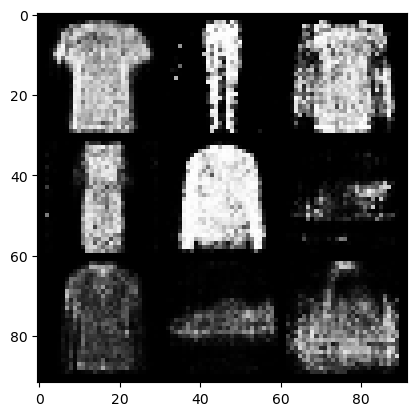

In [14]:
for epoch in range(epochs):
    
    print('Starting epoch {}...'.format(epoch+1))
    
    for i, (images, labels) in enumerate(train_loader):
        
        # Train data
        real_images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        
        # Set generator train
        generator.train()
        
        # Train discriminator
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        
        # Train generator
        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    
    # Set generator eval
    generator.eval()
    
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    
    # Building z 
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    
    # Labels 0 ~ 8
    labels = Variable(torch.LongTensor(np.arange(class_num-1))).to(device)
    
    # Generating images
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    
    # Show images
grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()

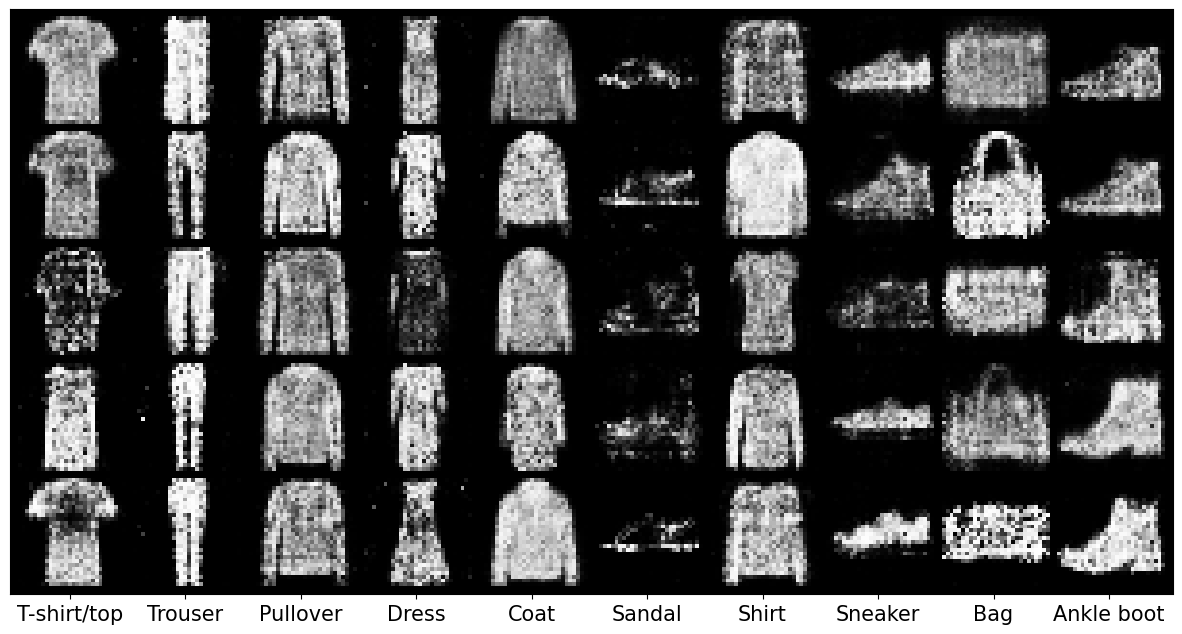

In [16]:
# generator.load_state_dict(torch.load("generator.pth"))
# discriminator.load_state_dict(torch.load("discriminator.pth"))

# Building z 
z = Variable(torch.randn(5*10, z_size)).to(device)

# Labels 0 ~ 9
labels = Variable(torch.LongTensor([i for _ in range(5) for i in range(class_num)])).to(device)

# Generating images
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

# Show images
grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
# _ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)
_ = plt.xticks(np.arange(15, 300, 30), class_list, fontsize=15)

torch.save(generator.state_dict(),"generator_git.pth")
torch.save(discriminator.state_dict(), "discriminator_git.pth")